In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np

from sparcscore.pipeline.project import Project
from sparcscore.pipeline.workflows import CytosolSegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction
from sparcscore.pipeline.classification import CellFeaturizer
from sparcscore.pipeline.selection import LMDSelection

In [2]:
project_location = f"project"

project = Project(os.path.abspath(project_location),
                  config_path= "config_example4.yml",
                  overwrite=True,
                  debug=True,
                  segmentation_f=CytosolSegmentationCellpose,
                  extraction_f=HDF5CellExtraction,
                  classification_f=CellFeaturizer,
                  selection_f=LMDSelection
                  )

modifying config
[02/08/2024 16:07:16] Loading config from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/config.yml
[02/08/2024 16:07:16] Loading classes from default classes path: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/segmentation/classes.csv
[02/08/2024 16:07:16] Created new directory /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/classification/0_Ch4_Featurization
[02/08/2024 16:07:16] current run: 0


In [3]:
#these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = ["./input_images/ch1.tif",
          "./input_images/ch2.tif",
          "./input_images/ch3.tif"]

project.load_input_from_tif_files(images)

[02/08/2024 16:07:16] saved input_image: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/input_image.ome.zarr


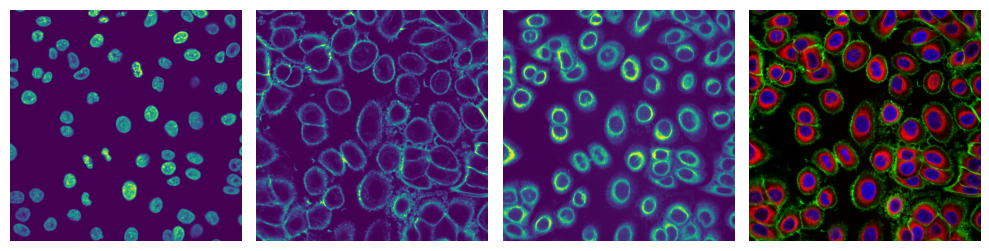

In [4]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color

def generate_composite(images, colors = [(0, 0, 1),(0, 1, 0), (1, 0, 0), (1, 0, 1)], plot = False):
    colorized = []
    for image, color in zip(images, colors):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized)-1):
        image += colorized[i+1]

    return(np.clip(image, 0, 1))

fig, axs = plt.subplots(1, 4, figsize = (10, 4));
axs[0].imshow(project.input_image[0]);
axs[0].axis("off");

axs[1].imshow(project.input_image[1]);
axs[1].axis("off");

axs[2].imshow(project.input_image[2]);
axs[2].axis("off");

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off");

fig.tight_layout()

[02/08/2024 16:07:17] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_w4l7wsb5 for CytosolSegmentationCellpose
[02/08/2024 16:07:17] GPU Status for segmentation is True and will segment using the following device mps.
[02/08/2024 16:07:17] Segmenting nucleus using the following model: nuclei
[02/08/2024 16:07:34] Segmenting cytosol using the following model: cyto2
[02/08/2024 16:09:25] Performing filtering to match Cytosol and Nucleus IDs.
[02/08/2024 16:09:26] Removed 15 nuclei and 5 cytosols due to filtering.
[02/08/2024 16:09:26] After filtering, 41 matching nuclei and cytosol masks remain.
[02/08/2024 16:09:27] Total time to perform nucleus and cytosol mask matching filtering: 1.71 seconds
[02/08/2024 16:09:27] Filtering status for this segmentation is set to True.
[02/08/2024 16:09:27] Filtering has been performed during segmentation. Nucleus and Cytosol IDs match. No additional steps are required.
[02/08/2024 16:09

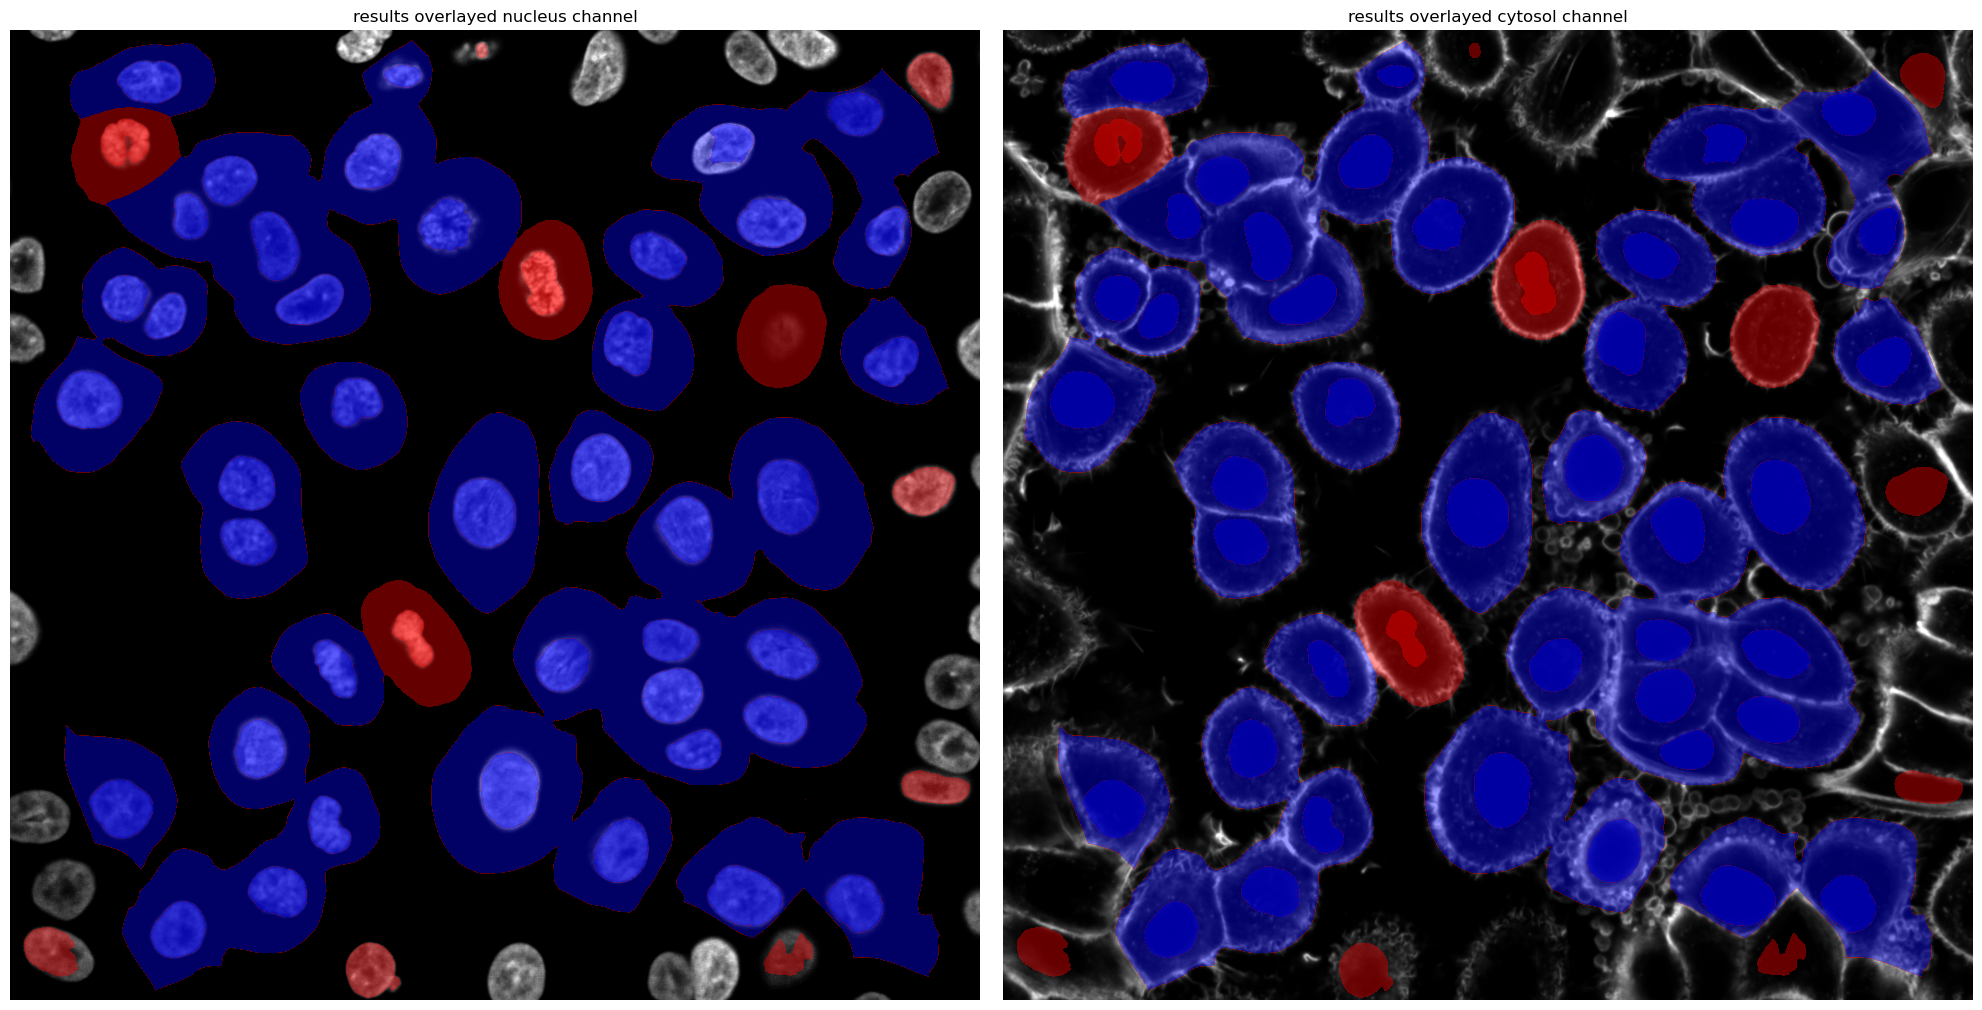

In [5]:
project.segment()

<HDF5 dataset "labels": shape (2, 2159, 2159), type "<u8">


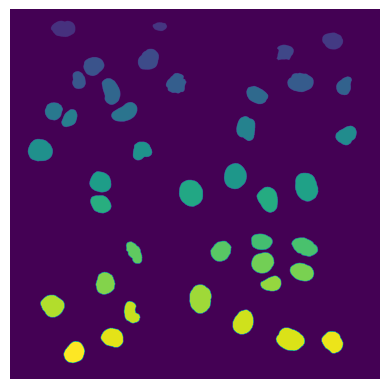

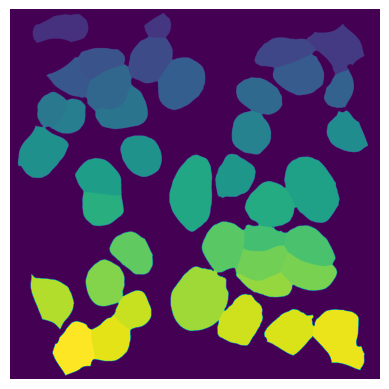

In [6]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")

In [7]:
project.extract()

[02/08/2024 16:09:29] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_j5bywim6 for HDF5CellExtraction
[02/08/2024 16:09:29] Created new data directory /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data
[02/08/2024 16:09:29] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data
[02/08/2024 16:09:29] Using segmentation <HDF5 dataset "labels": shape (2, 2159, 2159), type "<u8">
[02/08/2024 16:09:29] Using channel information <HDF5 dataset "channels": shape (3, 2159, 2159), type "<u2">
[02/08/2024 16:09:29] Loaded 41 cellIds to extract.
[02/08/2024 16:09:29] After removing duplicates 41 cells remain.
[02/08/2024 16:09:29] Started cell coordinate calculation
[02/08/2024 16:09:30] Finished cell coordinate calculation
[02/08/2024 16:09:30] Cell coordinates saved to file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4

Processing cell batches:   0%|          | 0/41 [00:00<?, ?it/s]

multiprocessing done.
[02/08/2024 16:09:31] Finished extraction in 0.52 seconds (78.63 cells / second)
[02/08/2024 16:09:31] Transferring results to final HDF5 data container.
[02/08/2024 16:09:31] number of cells too close to image edges to extract: 6
[02/08/2024 16:09:31] A total of 6 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/segmentation/removed_classes_too_close_to_edges.csv.
[02/08/2024 16:09:31] Transferring extracted single cells to .hdf5
[02/08/2024 16:09:31] single-cell index created.
[02/08/2024 16:09:31] single-cell data created
[02/08/2024 16:09:31] single-cell index labelled created.
[02/08/2024 16:09:31] channel information created.
[02/08/2024 16:09:31] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_j5bywim6'>


(35, 5, 400, 400)


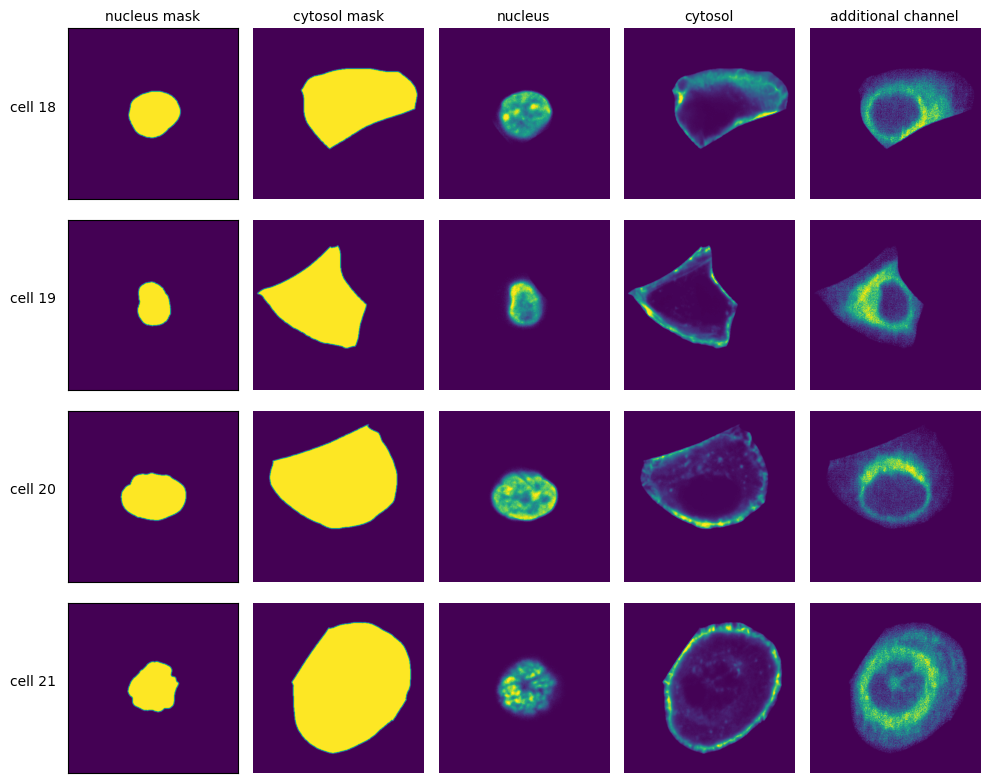

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize = (5*2, len(n_cells)*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img, vmin = 0, vmax = 1)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

In [9]:
project.classify(accessory = [(), (), ()])

[02/08/2024 16:09:32] Started classification
[02/08/2024 16:09:32] starting with run 0
[02/08/2024 16:09:32] channel_classification: 4
[02/08/2024 16:09:32] batch_size: 900
[02/08/2024 16:09:32] dataloader_worker_number: 0
[02/08/2024 16:09:32] inference_device: cpu
[02/08/2024 16:09:32] screen_label: Ch4_Featurization
[02/08/2024 16:09:32] 0 different accessory datasets specified
[02/08/2024 16:09:32] loading /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data
[02/08/2024 16:09:32] Adding hdf5 file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_4/project/extraction/data/single_cells.h5 to index...
Total: 35
0: 35

[02/08/2024 16:09:32] start processing 1 batches
[02/08/2024 16:09:32] finished processing


/Users/sophia/mambaforge/envs/SPARCSspatial-dev/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [11]:
#load classification results
results = pd.read_csv(f"{project_location}/classification/0_Ch4_Featurization/calculated_features.csv", index_col = 0)
results

,nucleus_area,cytosol_area,mean,median,quant75,quant25,summed_intensity_nucleus_area,summed_intensity_cytosol_area,summed_intensity_nucleus_area_normalized,summed_intensity_cytosol_area_normalized,label,cell_id
0,10701.0,48310.0,0.084756,0.000000,0.055054,0.0,3950.6716,13560.9300,0.369187,0.280706,0,36
1,15317.0,59838.0,0.083962,0.000000,0.089294,0.0,7024.7363,13433.8910,0.458624,0.224504,0,65
2,19152.0,85260.0,0.135170,0.009903,0.197998,0.0,5221.9507,21627.1780,0.272658,0.253661,0,42
3,11462.0,41617.0,0.078814,0.000000,0.000003,0.0,3655.6940,12610.2150,0.318940,0.303006,0,44
4,10037.0,38690.0,0.061237,0.000000,0.000000,0.0,3299.5393,9797.9220,0.328738,0.253242,0,64
5,14523.0,47223.0,0.084104,0.000000,0.097107,0.0,4180.7827,13456.6420,0.287873,0.284959,0,55
6,18707.0,55875.0,0.089277,0.000000,0.089294,0.0,5167.9165,14284.3940,0.276256,0.255649,0,66
7,13898.0,48755.0,0.066679,0.000000,0.048065,0.0,3969.2876,10668.5780,0.285601,0.218820,0,31
8,13727.0,48210.0,0.079961,0.000000,0.044647,0.0,4652.6567,12793.8360,0.338942,0.265377,0,39
9,13195.0,48302.0,0.087412,0.000000,0.079224,0.0,3756.0398,13985.9090,0.284656,0.289551,0,56


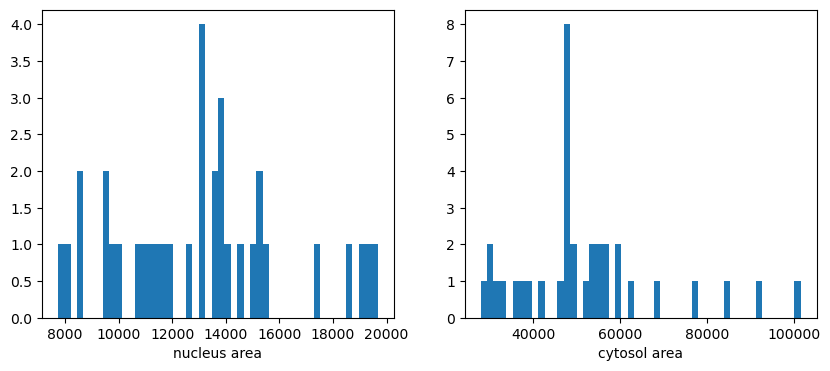

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs[0].hist(results["nucleus_area"], bins = 50)
axs[0].set_xlabel("nucleus area");

axs[1].hist(results["cytosol_area"], bins = 50)
axs[1].set_xlabel("cytosol area");